# Beta Lag Research
## Import Packages

In [22]:
import datetime as dt
import pandas as pd
import numpy as np
from pandas_datareader import data
import statsmodels.formula.api as sm
import time
import wmcm
import seaborn as sns
%matplotlib inline

## Load Universe
I created a CSV listing all stocks included in SPDR’s sector funds as of January 24th, 2016. It is loaded as a pandas dataframe. In order to make calls to Yahoo, all periods are replaced with hyphens.

We also pull all sector tickers and SPY as a proxy for the market as a whole.

In [2]:
universe_stocks = pd.read_csv('inputs/stocks.csv', index_col='symbol')
universe_stocks.index = map(lambda x: x.replace('.', '-'), universe_stocks.index)

universe_sectors = pd.read_csv('inputs/sectors.csv', index_col='symbol')
universe_sectors.index = map(lambda x: x.replace('.', '-'), universe_sectors.index)

# limited to a few stocks
# universe_stocks = universe_stocks.ix[['GOOG', 'PM', 'XOM']]
universe_stocks.head()

,company_name,index_weight,sector,sector_name
PG,Procter & Gamble,11.90%,XLP,Consumper Staples
KO,Coca-Cola Co,9.31%,XLP,Consumper Staples
PM,Philip Morris International,7.61%,XLP,Consumper Staples
CVS,CVS Health Corporation,6.16%,XLP,Consumper Staples
MO,Altria Group Inc,5.84%,XLP,Consumper Staples


## Pull Price History

Price history is pulled from Yahoo into separate Stock instances. Stocks were pulled from January 1st 2010 through December 31st, 2015.

In [3]:
stocks = wmcm.Universe(universe_stocks.index, 'SPY', interval='w', verbose=False)
stocks.save('sp500_uni.p')
#stocks = wmcm.Universe.load('sp500_uni.p')

ValueError occured for CCL
No Earnings Data found for FOX!
No Earnings Data found for DISCK!
ValueError occured for DISCA
ValueError occured for EOG
ValueError occured for BHI
ValueError occured for APA
ValueError occured for DVN
ValueError occured for OKE
No Earnings Data found for BRK-b!
Some other Error occured for WLTW
ValueError occured for REGN
ValueError occured for GWW
ValueError occured for CHRW
ValueError occured for LYB
ValueError occured for CBG
ValueError occured for ADP
ValueError occured for PNW


## Calculate Betas on Full Sample

In [4]:
## user-defined functions are allowed in formulas
def lag(x):
    return x.shift(1)

## create analysis_df
for key in stocks.keys():
    stocks[key].analysis_df = stocks[key].adj_returns

## fit GOOG with no earnings adjustments
model = stocks.factor_model('GOOG', 'ret_co ~ ret_co_market + lag(ret_oc)', filter_earnings=False)
model.params

Intercept        0.002727
ret_cc_market    0.945508
lag(ret_cc)     -0.375007
dtype: float64

In [9]:
## adjust analysis_df for lagged earnings
## a little long-winded but it just filters out
## periods proceeding earnings periods

## NEED TO CREATE LAGGED VARIABLE FIRST!!
## can't rely on user-generated lag-in-formula
for key in stocks.keys():
    if key=='market':
        pass
    else:
        stocks[key].analysis_df['lagged_ret_oc'] = stocks[key].analysis_df['ret_oc'].shift(1)
        stocks[key].analysis_df = stocks[key].analysis_df.loc[(stocks[key].analysis_df['earnings_period'].shift(1)==False)]

## fit all *with* earnings adjustments
## full models are stored in stocks.results which is a dictionary
stocks.factor_model_all('ret_co ~ ret_co_market + lagged_ret_oc', filter_earnings=True)
stocks.results['GOOG'].params['lagged_ret_oc']


-0.75452242862348207

using a non-integer number instead of an integer will result in an error in the future


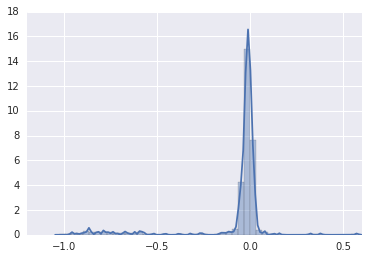

In [23]:
plot_data = pd.DataFrame({stock : stocks.results[stock].params['lagged_ret_oc'] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
sns.distplot(plot_data)